# Neural Style Transfer
In this notebook, I will demonstrate how to merge a style from an image to another image, using activations in pre-trained convolutional neural networks and transfer learning. The CNN I use is VGG19, and the goal is to combine Galarian slowpoke with styles in Fishing in Spring by Van Gogh.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe
from tensorflow.python.keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
%matplotlib inline
tf.enable_eager_execution()

Using TensorFlow backend.


Here are the images we intend to combine:

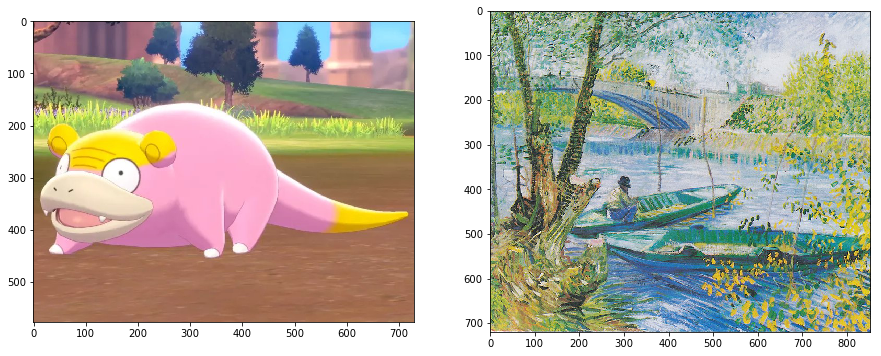

In [2]:
C = plt.imread("data/slowpoke.jpg")
S = plt.imread("data/fishing_in_spring.jpg")
_, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(C)
ax[1].imshow(S)

## Transfer learning using VGG19
First, let's load the pre-trained VGG19 CNN in Keras, and familar with its architecture.

In [3]:
vgg19 = tf.keras.applications.VGG19(weights="imagenet")
vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Loss function
The loss function for neural style transfer is comprised of two components - content loss and style loss. We want to minimize content loss so that the content of generated image $G$ is similar to content image $C$. At the same time, we also want to minimize style loss so that the generated image $G$ follows the style of style image $S$. We use $\beta$ to control the balance of two losses.
$$
L(G) = J_{content}(C, G) + \beta J_{style}(S, G)
$$

### Content loss
We use squared $L_2$ loss to measure difference in content between content image $C$ and generated image $G$. 

For activations  at layer $l$,
$$
L_{content}(C, G)=\left\lVert a^{[l]}_{C}-a^{[l]}_{G}\right\rVert_2^2
$$

In [4]:
def content_loss(a1, a2):
    return tf.reduce_sum((a1 - a2) ** 2)

### Style loss
To capture style of an image, we compute (unnormalized) covariance matrix $\Sigma^{[l]}$ between all pairs of channels at layer $l$. The off-diagonal terms capture how frequent two features appear together, and the diagonal terms capture how intense a feature is in the image.

$$
\Sigma_{ij}^{[l]}=a_{C,::i}^{[l]\top}a_{C,::j}^{[l]}
$$

In [5]:
def covariance(a):
    # a has dimension depth x height x width
    # number of channels is the first dimension
    depth = a.shape[0]
    a_reshaped = tf.reshape(a, [depth, -1])
    return a_reshaped @ tf.transpose(a_reshaped)

We again use squared $L_2$ loss (i.e. squared Frobenius norm) to measure difference in style between style image $S$ and generated image $G$.

For activations at layer $l$,
$$
L_{style}^{[l]}(S, G)=\left\lVert \Sigma^{[l]}_{C}-\Sigma^{[l]}_{G}\right\rVert_F^2
$$

We use weights $\lambda^{[l]}$ to combine styles at different scales (i.e. using different layers), so the total style loss is

$$
L_{style}(S, G)=\sum_{l}\lambda^{[l]} L_{style}^{[l]}(S, G)
$$
where $\sum_{l}\lambda^{[l]}=1$.

In [6]:
def style_layer_loss(a1, a2):
    # a has dimension height x width x depth
    sigma1 = covariance(tf.transpose(a1, perm=[2, 0, 1]))
    sigma2 = covariance(tf.transpose(a2, perm=[2, 0, 1]))
    return tf.reduce_sum((sigma1 - sigma2) ** 2)

We will use 5 hidden layers of VGG19, namely *block1_conv1*, *block2_conv1*, *block3_conv1*, *block4_conv1*, and *block5_conv1*, to compute style loss. 

In [7]:
# use 5 hidden layers with equal weights for style
weights = [("block1_conv1", 0.2),
           ("block2_conv1", 0.2),
           ("block3_conv1", 0.2),
           ("block4_conv1", 0.2),
           ("block5_conv1", 0.2)]

Finally, we combine both content loss and style loss, with $\beta=2$. We use *block4_conv1* to compute content loss. 

For Keras implementation, we concatenate content image, style image, and generated image, and feed them together as a batch into VGG19. The input size does not have to be $224\times224$ because of the nature of convolution.

In [8]:
# create a model that outputs intermediate activations for above 5 hidden layers
model = Model(inputs = vgg19.inputs, outputs=[vgg19.get_layer(i).output for i, j in weights])

def tot_loss(C, S, G, beta=2):
    x = tf.concat([C, S, G], axis=0)
    # forward propagation
    activations = model(x)
    
    # content loss
    a4_C = activations[3][0]
    a4_G = activations[3][2]
    # with normalization constant
    loss = content_loss(a4_C, a4_G) / (4 * 300 * 380 * 3)
    
    # style loss
    for layer in range(len(weights)):
        a_S = activations[layer][1]
        a_G = activations[layer][2]
        # with normalization constant
        loss += beta * weights[layer][1] * style_layer_loss(a_S, a_G) / (4 * 300 ** 2 * 380 ** 2 * 9)
    return loss

## Image processing

- Although we don't need $224\times224$ input images, we do need bot content image and style image to be the same size. We first resize the images to $300\times380$ so that they have the same dimension.
- We need the correct input for VGG19. All input of VGG10 has been substracted with mean pixel values (123.68, 116.779, 103.939) for RGB channels.
- Channels in VGG19 are in the order of BGR.

In [9]:
class preprocessing:
    def __init__(self, height, width):
        self.height = height
        self.width = width
    
    def forward(self, path):
        img = img_to_array(load_img(path, target_size=(self.height, self.width)))
        # substract mean
        img[0] -= 123.68
        img[1] -= 116.779
        img[2] -= 103.939
        # convert from RGB to BGR
        img = np.expand_dims(img[:, :, ::-1], axis=0)
        return img
        
    def backward(self, img):
        img = img[0]
        # add back mean
        img[0] += 103.939
        img[1] += 116.779
        img[2] += 123.68
        # clip values between 0 and 255
        # convert from BGR to RGB
        return np.clip(img, 0, 255).astype("uint8")[:, :, ::-1]

In [10]:
height, width = 300, 380
processor = preprocessing(height, width)
C = processor.forward("data/slowpoke.jpg")
S = processor.forward("data/fishing_in_spring.jpg")

## Optimization with gradient descent

We don't want to update the weights in VGG19 and the only parameters we want to update are the values in $G$. That is, we want to freeze the layers in VGG19. We use Adam optimizer to update parameters in $G$, with 500 iterations. We initialize $G$ as the same image as content image $C$.

In [11]:
optimizer = tf.train.AdamOptimizer(learning_rate=3, beta1=0.9, beta2=0.999)
def compute_grads(C, S, G):
    with tf.GradientTape() as tape:
        loss = tot_loss(C, S, G)
    grads = tape.gradient(loss, G)
    return loss, grads

In [12]:
G = tfe.Variable(C, validate_shape=False)
for i in range(1, 501):
    # only update parameters in G
    loss, grads = compute_grads(C, S, G)
    optimizer.apply_gradients([(grads, G)])
    if i == 1 or i % 25 == 0:
        print("Iteration {}: loss = {}".format(i, loss))    

Iteration 1: loss = 289483587584.0
Iteration 25: loss = 7779909632.0
Iteration 50: loss = 3561545216.0
Iteration 75: loss = 2368602112.0
Iteration 100: loss = 1825594624.0
Iteration 125: loss = 1476399360.0
Iteration 150: loss = 1222858624.0
Iteration 175: loss = 1029718336.0
Iteration 200: loss = 878187392.0
Iteration 225: loss = 756442752.0
Iteration 250: loss = 657159296.0
Iteration 275: loss = 575159168.0
Iteration 300: loss = 506631488.0
Iteration 325: loss = 449116096.0
Iteration 350: loss = 400385344.0
Iteration 375: loss = 358976160.0
Iteration 400: loss = 323814656.0
Iteration 425: loss = 293976960.0
Iteration 450: loss = 268542528.0
Iteration 475: loss = 246793856.0
Iteration 500: loss = 228185504.0


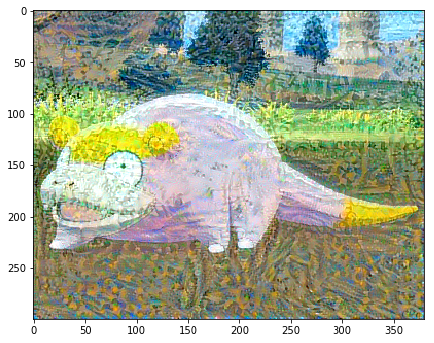

In [13]:
img = processor.backward(G.numpy())
plt.figure(figsize=(7, 7))
plt.imshow(img)